
# OZON RecSys Baseline - Рекомендательная система для категории Apparel
Этот ноутбук содержит базовое решение для задачи предсказания следующей покупки пользователя в категории одежды, обуви и аксессуаров.

## Задача
- Предсказать топ-100 товаров для каждого пользователя из тестовой выборки
- Метрика оценки: NDCG@100
- Данные: ~38GB в формате parquet, 1.6B взаимодействий, 19M заказов


In [1]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from collections import defaultdict
import subprocess
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Загрузка и анализ данных


In [2]:
def load_train_data():

    print("Загружаем тренировочные данные...")
    
    orders_files = glob.glob('ml_ozon_recsys_train/final_apparel_orders_data/*.parquet')
    tracker_files = glob.glob('ml_ozon_recsys_train/final_apparel_tracker_data/*.parquet')
    items_files = glob.glob('ml_ozon_recsys_train/final_apparel_items_data/*.parquet')
    
    print(f"Найдено файлов заказов: {len(orders_files)}")
    print(f"Найдено файлов взаимодействий: {len(tracker_files)}")
    print(f"Найдено файлов товаров: {len(items_files)}")
    
    orders_data = []
    for file_path in tqdm(orders_files, desc="Загрузка заказов"):
        df = pd.read_parquet(file_path)
        orders_data.append(df)
    orders_df = pd.concat(orders_data, ignore_index=True)
    print(f"Загружено заказов: {len(orders_df):,}")
    
    tracker_data = []
    for file_path in tqdm(tracker_files[:20], desc="Загрузка взаимодействий"):
        df = pd.read_parquet(file_path)
        tracker_data.append(df)
    tracker_df = pd.concat(tracker_data, ignore_index=True)
    print(f"Загружено взаимодействий: {len(tracker_df):,}")
    
    items_data = []
    for file_path in tqdm(items_files[:10], desc="Загрузка товаров"):
        df = pd.read_parquet(file_path)
        items_data.append(df)
    items_df = pd.concat(items_data, ignore_index=True)
    print(f"Загружено товаров: {len(items_df):,}")
    
    return orders_df, tracker_df, items_df


In [3]:
orders_df, tracker_df, items_df = load_train_data()

Загружаем тренировочные данные...
Найдено файлов заказов: 5
Найдено файлов взаимодействий: 200
Найдено файлов товаров: 100


Загрузка заказов: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Загружено заказов: 18,887,122


Загрузка взаимодействий: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Загружено взаимодействий: 164,241,333


Загрузка товаров: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Загружено товаров: 644,381


## 2. Exploratory Data Analysis (EDA)


In [4]:

print("АНАЛИЗ ЗАКАЗОВ")
print("=" * 50)
print(f"Общее количество заказов: {len(orders_df):,}")
print(f"Уникальных пользователей: {orders_df['user_id'].nunique():,}")
print(f"Уникальных товаров: {orders_df['item_id'].nunique():,}")
print(f"Период данных: {orders_df['created_date'].min()} - {orders_df['created_date'].max()}")

print("\nРаспределение статусов заказов:")
status_counts = orders_df['last_status'].value_counts()
for status, count in status_counts.items():
    percentage = count / len(orders_df) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")


АНАЛИЗ ЗАКАЗОВ
Общее количество заказов: 18,887,122
Уникальных пользователей: 834,137
Уникальных товаров: 4,673,763
Период данных: 2025-01-01 - 2025-07-01

Распределение статусов заказов:
  delivered_orders: 9,936,249 (52.6%)
  canceled_orders: 7,990,577 (42.3%)
  proccesed_orders: 960,296 (5.1%)


In [6]:
print("\n АНАЛИЗ ВЗАИМОДЕЙСТВИЙ")
print("=" * 50)
print(f"Общее количество взаимодействий: {len(tracker_df):,}")
print(f"Уникальных пользователей: {tracker_df['user_id'].nunique():,}")
print(f"Уникальных товаров: {tracker_df['item_id'].nunique():,}")

print("\nРаспределение типов действий:")
action_counts = tracker_df['action_type'].value_counts()
for action, count in action_counts.items():
    percentage = count / len(tracker_df) * 100
    print(f"  {action}: {count:,} ({percentage:.1f}%)")



 АНАЛИЗ ВЗАИМОДЕЙСТВИЙ
Общее количество взаимодействий: 164,241,333
Уникальных пользователей: 981,725
Уникальных товаров: 490,379

Распределение типов действий:
  page_view: 117,545,260 (71.6%)
  view_description: 22,111,951 (13.5%)
  review_view: 7,593,543 (4.6%)
  to_cart: 6,096,416 (3.7%)
  favorite: 5,199,691 (3.2%)
  remove: 3,712,297 (2.3%)
  unfavorite: 1,982,175 (1.2%)


In [8]:
print("\nАНАЛИЗ ТОВАРОВ")
print("=" * 50)
print(f"Общее количество товаров: {len(items_df):,}")
print(f"Товары с названием: {items_df['itemname'].notna().sum():,}")
print(f"Товары с эмбеддингами: {items_df['fclip_embed'].notna().sum():,}")

if 'attributes' in items_df.columns:
    print(f"Товары с атрибутами: {items_df['attributes'].notna().sum():,}")

print("\nТоп-10 категорий:")
top_categories = items_df['catalogid'].value_counts().head(10)
for cat_id, count in top_categories.items():
    print(f"  Категория {cat_id}: {count:,}")


АНАЛИЗ ТОВАРОВ
Общее количество товаров: 644,381
Товары с названием: 644,381
Товары с эмбеддингами: 644,381
Товары с атрибутами: 644,381

Топ-10 категорий:
  Категория 7559: 41,289
  Категория 7508: 26,937
  Категория 36484: 22,597
  Категория 7660: 21,969
  Категория 7502: 20,128
  Категория 7512: 11,940
  Категория 7511: 10,701
  Категория 7530: 10,629
  Категория 17002: 10,543
  Категория 7644: 10,200


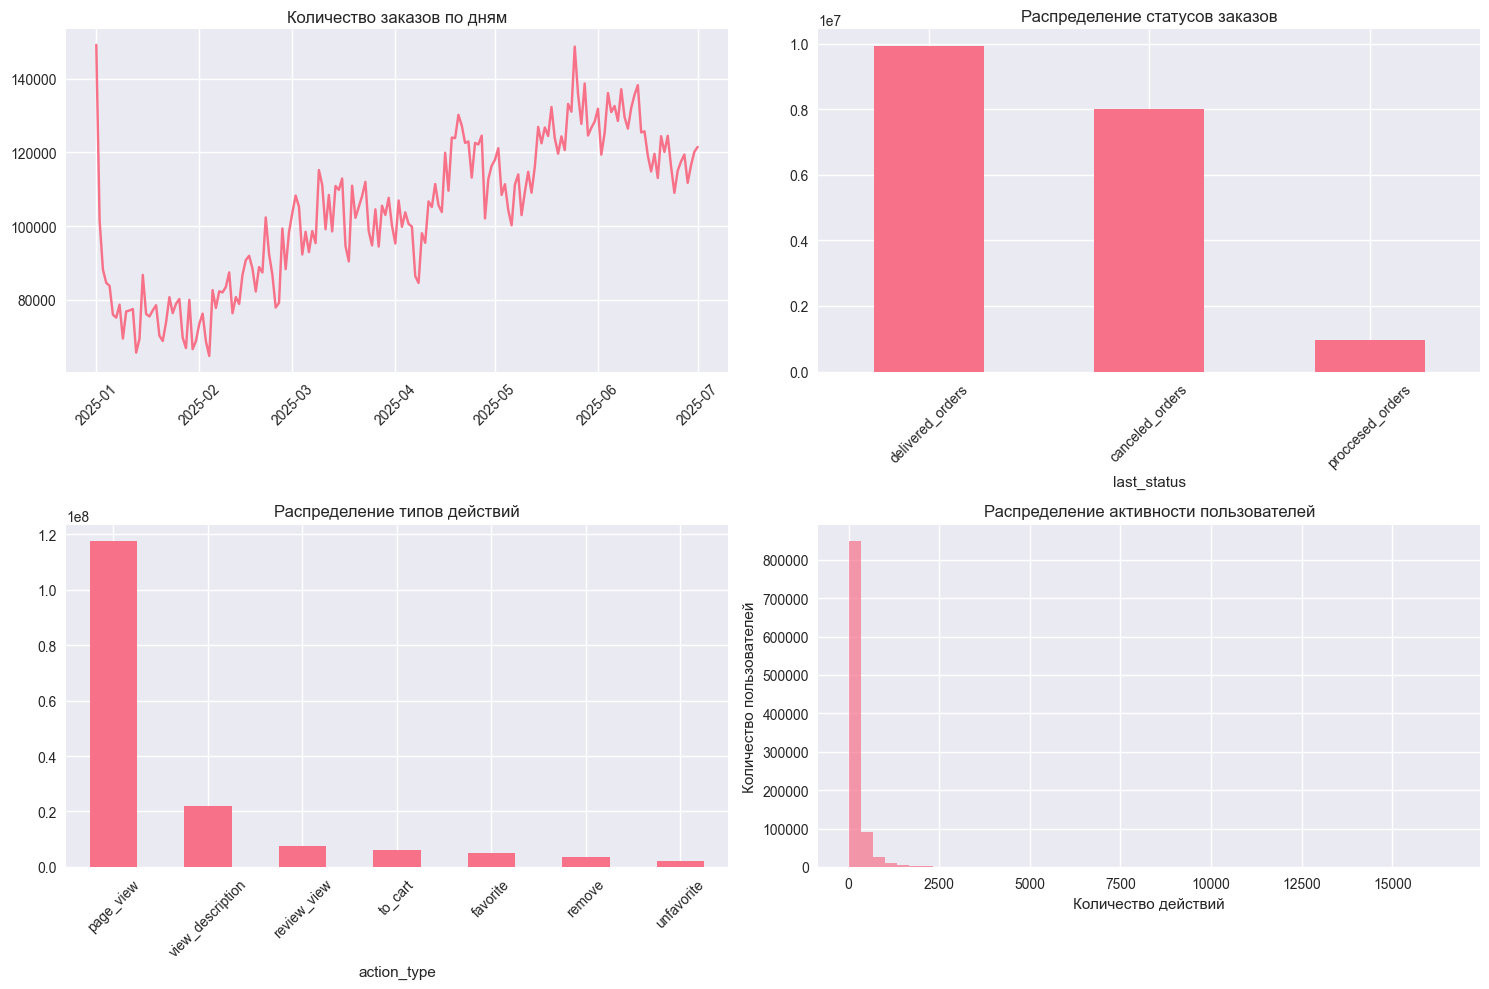

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

orders_df['created_date'] = pd.to_datetime(orders_df['created_date'])
daily_orders = orders_df.groupby('created_date').size()
axes[0, 0].plot(daily_orders.index, daily_orders.values)
axes[0, 0].set_title('Количество заказов по дням')
axes[0, 0].tick_params(axis='x', rotation=45)

status_counts.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Распределение статусов заказов')
axes[0, 1].tick_params(axis='x', rotation=45)

action_counts.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Распределение типов действий')
axes[1, 0].tick_params(axis='x', rotation=45)

user_activity = tracker_df['user_id'].value_counts()
axes[1, 1].hist(user_activity.values, bins=50, alpha=0.7)
axes[1, 1].set_title('Распределение активности пользователей')
axes[1, 1].set_xlabel('Количество действий')
axes[1, 1].set_ylabel('Количество пользователей')

plt.tight_layout()
plt.show()

## 3. Загрузка тестовых пользователей

In [10]:
def load_test_users():

    print("Загружаем тестовых пользователей...")
    
    test_files = glob.glob('test_for_participants/*/*.parquet')
    all_users = set()
    
    for file_path in tqdm(test_files, desc="Обработка тестовых файлов"):
        df = pd.read_parquet(file_path)
        all_users.update(df['user_id'].unique())
    
    print(f"Найдено уникальных тестовых пользователей: {len(all_users):,}")
    return list(all_users)

test_users = load_test_users()

Загружаем тестовых пользователей...


Обработка тестовых файлов: 100%|██████████| 70/70 [00:00<00:00, 351.11it/s]

Найдено уникальных тестовых пользователей: 281,212


## 4. Построение модели на основе популярности

In [11]:
def build_popularity_model(orders_df, tracker_df):
    print("Строим модель популярности...")
    
    delivered_orders = orders_df[orders_df['last_status'] == 'delivered_orders']
    print(f"Доставленных заказов: {len(delivered_orders):,}")
    
    item_popularity = delivered_orders['item_id'].value_counts().to_dict()
    print(f"Уникальных купленных товаров: {len(item_popularity):,}")
    
    page_views = tracker_df[tracker_df['action_type'] == 'page_view']
    item_views = page_views['item_id'].value_counts().to_dict()
    print(f"Уникальных просмотренных товаров: {len(item_views):,}")
    
    combined_popularity = defaultdict(float)
    for item_id, count in item_popularity.items():
        combined_popularity[item_id] += count * 3.0
    
    for item_id, count in item_views.items():
        combined_popularity[item_id] += count * 1.0
    
    popular_items = sorted(combined_popularity.items(), key=lambda x: x[1], reverse=True)
    top_items = [item_id for item_id, score in popular_items[:200]]
    
    print(f"Отобрано топ-{len(top_items)} популярных товаров")
    
    top_10_items = popular_items[:10]
    print("\nТоп-10 самых популярных товаров:")
    for i, (item_id, score) in enumerate(top_10_items, 1):
        print(f"  {i}. Товар {item_id}: {score:.1f} баллов")
    
    return top_items

popular_items = build_popularity_model(orders_df, tracker_df)


Строим модель популярности...
Доставленных заказов: 9,936,249
Уникальных купленных товаров: 3,066,495
Уникальных просмотренных товаров: 490,111
Отобрано топ-200 популярных товаров

Топ-10 самых популярных товаров:
  1. Товар 51974017: 254769.0 баллов
  2. Товар 110485480: 67526.0 баллов
  3. Товар 301902796: 66822.0 баллов
  4. Товар 110502882: 62536.0 баллов
  5. Товар 290421996: 45317.0 баллов
  6. Товар 125399986: 42127.0 баллов
  7. Товар 156274404: 41733.0 баллов
  8. Товар 91818697: 37018.0 баллов
  9. Товар 302268432: 34891.0 баллов
  10. Товар 148719804: 34388.0 баллов


In [12]:
def build_user_preferences(orders_df, tracker_df, test_users):

    print("Строим пользовательские предпочтения...")
    
    delivered_orders = orders_df[orders_df['last_status'] == 'delivered_orders']
    user_purchased_items = delivered_orders.groupby('user_id')['item_id'].apply(list).to_dict()
    print(f"Пользователей с покупками: {len(user_purchased_items):,}")
    
    user_viewed_items = tracker_df[tracker_df['action_type'] == 'page_view'].groupby('user_id')['item_id'].apply(list).to_dict()
    print(f"Пользователей с просмотрами: {len(user_viewed_items):,}")
    
    user_preferences = {}
    users_with_history = 0
    
    for user_id in tqdm(test_users, desc="Обработка предпочтений"):
        preferences = set()
        
        if user_id in user_purchased_items:
            preferences.update(user_purchased_items[user_id])
        
        if user_id in user_viewed_items:
            preferences.update(user_viewed_items[user_id][:50])
        
        user_preferences[user_id] = list(preferences)
        
        if len(preferences) > 0:
            users_with_history += 1
    
    print(f"Построены предпочтения для {len(user_preferences):,} пользователей")
    print(f"Пользователей с историей: {users_with_history:,} ({users_with_history/len(test_users)*100:.1f}%)")
    
    return user_preferences

user_preferences = build_user_preferences(orders_df, tracker_df, test_users)


Строим пользовательские предпочтения...
Пользователей с покупками: 799,449
Пользователей с просмотрами: 979,963


Обработка предпочтений: 100%|██████████| 281212/281212 [00:03<00:00, 87550.22it/s] 


Построены предпочтения для 281,212 пользователей
Пользователей с историей: 280,794 (99.9%)


## 6. Генерация рекомендаций

In [13]:
def generate_recommendations(test_users, popular_items, user_preferences):

    print("Генерируем рекомендации...")
    
    recommendations = {}
    
    for user_id in tqdm(test_users, desc="Создание рекомендаций"):
        user_recs = []
        
        user_items = set(user_preferences.get(user_id, []))
        
        available_items = [item for item in popular_items if item not in user_items]
        
        if len(available_items) >= 100:
            user_recs = available_items[:100]
        else:
            user_recs = available_items + popular_items[:100-len(available_items)]
        
        if len(user_recs) < 100:
            remaining = 100 - len(user_recs)
            random_items = np.random.choice(popular_items, remaining, replace=True)
            user_recs.extend(random_items)
        
        recommendations[user_id] = user_recs[:100]
    
    print(f"Сгенерированы рекомендации для {len(recommendations):,} пользователей")
    
    rec_lengths = [len(recs) for recs in recommendations.values()]
    print(f"Средняя длина рекомендаций: {np.mean(rec_lengths):.1f}")
    print(f"Все рекомендации имеют 100 товаров: {all(l == 100 for l in rec_lengths)}")
    
    return recommendations

recommendations = generate_recommendations(test_users, popular_items, user_preferences)


Генерируем рекомендации...


Создание рекомендаций: 100%|██████████| 281212/281212 [00:02<00:00, 125098.69it/s]

Сгенерированы рекомендации для 281,212 пользователей
Средняя длина рекомендаций: 100.0
Все рекомендации имеют 100 товаров: True


## 7. Создание файла submission

In [14]:
def create_submission(recommendations, filename='baseline_submission.csv'):

    print(f"Создаем файл submission: {filename}")
    
    submission_data = []
    for user_id, items in tqdm(recommendations.items(), desc="Формирование submission"):
        submission_data.append({
            'user_id': user_id,
            'item_id_1 item_id_2 ... item_id_100': ' '.join(map(str, items))
        })
    
    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(filename, index=False)
    
    print(f"Сохранен submission с {len(submission_df):,} пользователями")
    print(f"Размер файла: {Path(filename).stat().st_size / 1024 / 1024:.1f} MB")
    
    return filename

submission_file = create_submission(recommendations)

Создаем файл submission: baseline_submission.csv


Формирование submission: 100%|██████████| 281212/281212 [00:03<00:00, 78687.20it/s] 


Сохранен submission с 281,212 пользователями
Размер файла: 264.0 MB
